**All edge statistics**

This notebook generates correlation plots for data of this study of the raw DDG edges. 

Analysis adapted from freenergyframework and a plotting example by Hannah Bruce McDonald:
https://github.com/choderalab/freeenergyframework/blob/master/freeenergyframework/examples/WhyNotToUseR2ForDDG.ipynb

In [32]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import sklearn.metrics
import scipy.stats
import copy
import os

sns.set_context("notebook", font_scale=1.2)

Populating the interactive namespace from numpy and matplotlib


In [33]:
def compute_statistic(y_true_sample, y_pred_sample):
    """Compute requested statistic.

    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho']

    """
    RMSE = np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
    MUE = sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
    _, _, r_value, _, _ = scipy.stats.linregress(y_true_sample, y_pred_sample)
    rho = scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
    tau = scipy.stats.kendalltau(y_true_sample, y_pred_sample)[0]
    return RMSE, MUE, r_value, rho, tau

In [34]:
def plotting_data(x,y, error=None):
    fig = figure(figsize=(6,6))
    xmin = min(x)
    xmax = max(x)
    corrline = np.linspace(-xmax,xmax,10)

    plt.plot(corrline,corrline, 'k-', alpha=0.5, lw=0.5)

    plt.fill_between(corrline, corrline-1, corrline+1, color='gray', alpha=0.2)
    plt.plot([0, 0], [-xmax, xmax], 'k:', lw=0.5)
    plt.plot([-xmax, xmax], [0, 0], 'k:', lw=0.5)
#     plt.plot([-xmin, -xmax], [xmin, xmax], 'k:')    
    
    plt.errorbar(x,y, yerr=error, lw=0,elinewidth=2, marker='o' )
    title = []
    RMSE, MUE, r_value, rho, tau = compute_statistic(x,y)
    plt.title(f'RMSE:{RMSE:.2}\n MUE:{MUE:.2}\n R:{r_value:.2}\n rho:{rho:.2}\n tau:{tau:.2}\n')
    #plt.show()
    sns.despine()
    plt.xlabel(r'experimental $\Delta \Delta$G [kcal/mol] ')
    plt.ylabel(r'computed $\Delta \Delta$G [kcal/mol]')
    return RMSE, MUE, r_value, rho, tau

In [126]:
def plotting_data_comput(x,y, error_x=None, error_y=None):
    fig = figure(figsize=(6,6))
    xmin = min(x)
    xmax = max(x)
    corrline = np.linspace(-xmax,xmax,10)

    plt.plot(corrline,corrline, 'k-', alpha=0.5, lw=0.5)

    plt.fill_between(corrline, corrline-1, corrline+1, color='gray', alpha=0.2)
    plt.plot([0, 0], [-xmax, xmax], 'k:', lw=0.5)
    plt.plot([-xmax, xmax], [0, 0], 'k:', lw=0.5)
#     plt.plot([-xmin, -xmax], [xmin, xmax], 'k:')    
    
    plt.errorbar(x,y,xerr=error_x, yerr=error_y, lw=0,elinewidth=2, marker='o' )
    title = []
    RMSE, MUE, r_value, rho, tau = compute_statistic(x,y)
    plt.title(f'RMSE:{RMSE:.2}\n MUE:{MUE:.2}\n R:{r_value:.2}\n rho:{rho:.2}\n tau:{tau:.2}\n')
    #plt.show()
    sns.despine()
    plt.xlabel(r'amber $\Delta \Delta$G [kcal/mol] ')
    plt.ylabel(r'qube $\Delta \Delta$G [kcal/mol]')
    return RMSE, MUE, r_value, rho, tau

## Reading data

In [69]:
def extract_computed_experimental(experi_data_name, computed_data_name, temperature=300):
    computed_df = pd.read_csv(computed_data_name,comment='#',names=['i', 'j','DDG', 'error'] )
    computed_df.i = computed_df.i.astype(str)
    computed_df.j = computed_df.j.astype(str)
    experi_df = pd.read_csv(experi_data_name, names=['name', 'IC_50'])
    experi_df.name = experi_df.name.astype(str)
    computed = []
    error_comput = []
    experiment = []
    for index, row in computed_df.iterrows():
        #print(row['i'], row['j'])
        #print(row['DDG'])
        i = experi_df.loc[experi_df['name'] == row['i']]
        j = experi_df.loc[experi_df['name'] == row['j']]
        ic_50_i = i['IC_50'].values[0]
        ic_50_j = j['IC_50'].values[0]
        dG = 0.0019872041 * temperature * np.log(ic_50_i/ic_50_j)
        experiment.append(dG)
        computed.append(row['DDG'])
        error_comput.append(row['error'])
    return experiment, computed, error_comput

In [127]:
def extract_comput_comput(amber_name,qube_name):
    computed_amber_df = pd.read_csv(amber_name,comment='#',names=['i', 'j','DDG', 'error'] )
    computed_amber_df.i = computed_amber_df.i.astype(str)
    computed_amber_df.j = computed_amber_df.j.astype(str)
    computed_qube_df = pd.read_csv(qube_name,comment='#',names=['i', 'j','DDG', 'error'] )
    computed_qube_df.i = computed_qube_df.i.astype(str)
    computed_qube_df.j = computed_qube_df.j.astype(str)
    computed_amber_df['pair'] = computed_amber_df['i']+computed_amber_df['j']
    computed_qube_df['pair'] = computed_qube_df['i']+computed_qube_df['j']
    amber = []
    qube = []
    error_amber = []
    error_qube = []
    for index, row in computed_qube_df.iterrows():
        i = computed_amber_df.loc[computed_amber_df['pair'] == row['pair']]
        if len(i['DDG'].values)> 0:
            amber.append(i['DDG'].values[0])
            error_amber.append(i['error'].values[0])
            qube.append(row['DDG'])
            error_qube.append(row['error'])
    return amber, qube, error_amber, error_qube



## Plotting data

### Group 1

### Qube

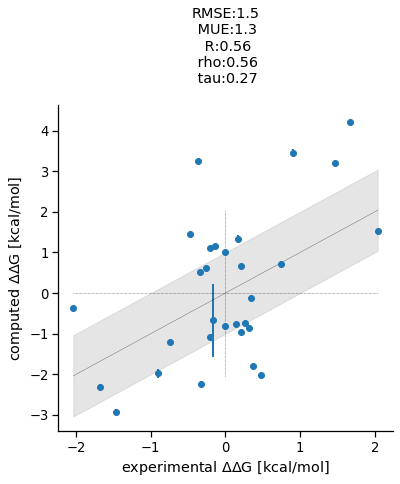

In [70]:
X,Y_qube,qube_error = extract_computed_experimental('group1/Group1_ic50_exp.csv', 'group1/G1_QUBE_summary.csv')
RMSE_start, MUE_start, R_start, rho_start, tau_start = plotting_data(X,Y_qube,qube_error)

### Amber

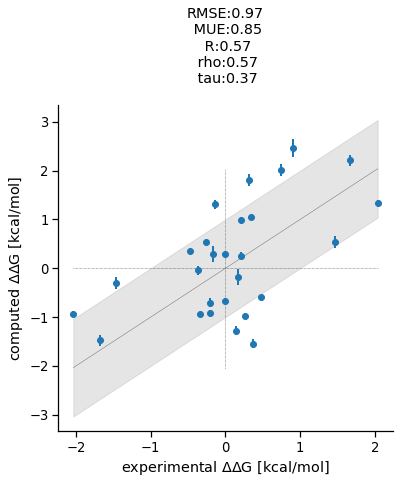

In [71]:
X,Y_amber,amber_error = extract_computed_experimental('group1/Group1_ic50_exp.csv', 'group1/G1_AMBER_summary.csv')
RMSE_start, MUE_start, R_start, rho_start, tau_start = plotting_data(X,Y_amber,amber_error)

### Qube v Amber

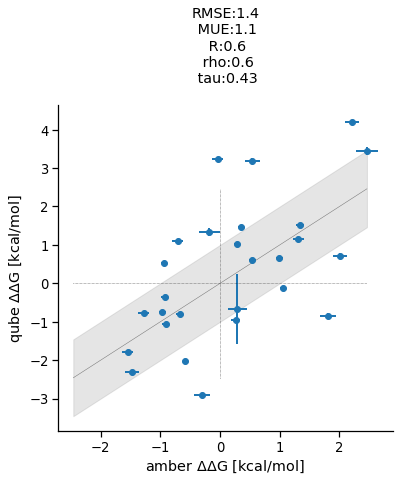

In [130]:
amber, qube, amber_error, queb_error = extract_comput_comput('group1/G1_AMBER_summary.csv','group1/G1_QUBE_summary.csv')
RMSE_start, MUE_start, R_start, rho_start, tau_start = plotting_data_comput(amber,qube,amber_error, queb_error)

### Group 2

### Qube

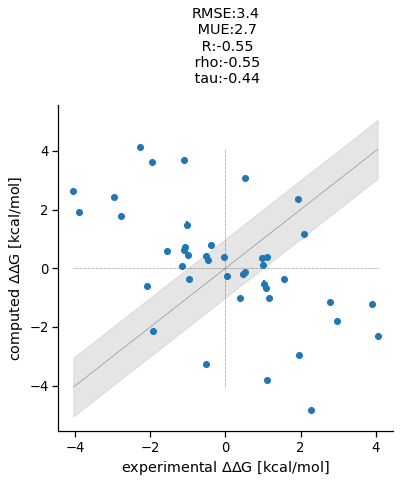

In [73]:
X,Y_qube,qube_error = extract_computed_experimental('group2/Group2_ic50_exp.csv', 'group2/G2_QUBE_summary.csv')
RMSE_start, MUE_start, R_start, rho_start, tau_start = plotting_data(X,Y_qube,qube_error)

### Amber

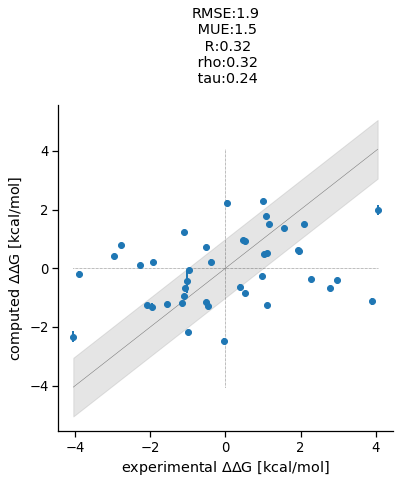

In [74]:
X,Y_amber,error_amber = extract_computed_experimental('group2/Group2_ic50_exp.csv', 'group2/G2_AMBER_summary.csv')
RMSE_start, MUE_start, R_start, rho_start, tau_start = plotting_data(X,Y_amber,error_amber)

### Qube v Amber

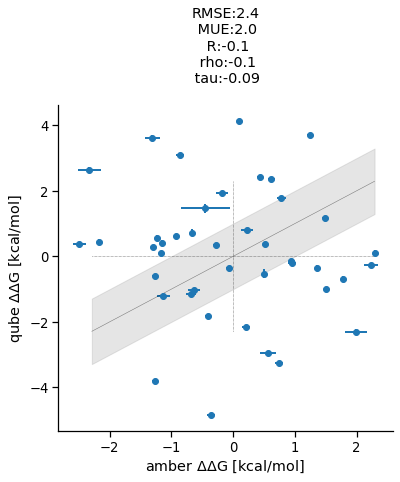

In [129]:
amber, qube, amber_error, queb_error = extract_comput_comput('group2/G2_AMBER_summary.csv','group2/G2_QUBE_summary.csv')
RMSE_start, MUE_start, R_start, rho_start, tau_start = plotting_data_comput(amber,qube,amber_error, queb_error)